In [217]:
# WikiRoute is a simple program that plans your commute with interesting geocoded wikipedia locations along the way!

In [218]:
def WikiRoute(startpoint,endpoint,bufferdistance):
    #import everything
    import geopy
    from geopy import distance
    import wikipedia
    import pandas as pd
    import numpy as np
    import osmnx as ox
    import networkx as nx
    from sklearn.neighbors import KDTree
    import folium
    import matplotlib.pyplot as plt
    %matplotlib inline
    import geopandas as gpd
    from shapely.geometry import Point
    import datetime
    starttime = datetime.datetime.now().strftime("%d-%m-%y_%H-%M")
    #midpoint calculation
    midpoint = (((startpoint[0]+endpoint[0])/2),((startpoint[1]+endpoint[1])/2))

    #radius calculation
    radius = geopy.distance.vincenty(startpoint, endpoint).m

    #OSM network pull
    G = ox.graph_from_point(midpoint, distance=radius)

    #define node/edge dfs
    nodes, edges= ox.graph_to_gdfs(G)

    #Closest network nodes to start/end points
    tree = KDTree(nodes[['y', 'x']], metric='euclidean')
    start_idx = tree.query([startpoint], k=1, return_distance=False)[0]
    end_idx = tree.query([endpoint], k=1, return_distance=False)[0]
    closest_node_to_start = nodes.iloc[start_idx].index.values[0]
    closest_node_to_end = nodes.iloc[end_idx].index.values[0]

    #creates original best route from start-end nodes
    route = nx.shortest_path(G, closest_node_to_start, closest_node_to_end)

    #filters to only nodes along route and buffers to capture the possible path deviations
    routestr = []
    for osmid in route:
        routestr.append(str(osmid))
    nodes['routepath'] = nodes['osmid'].isin(routestr)
    crs = {'init': 'epsg:4326'}
    pathbuffer = gpd.GeoDataFrame(nodes[nodes['routepath']==True], crs=crs)
    pathbuffer = pathbuffer.to_crs(epsg=3857)
    pathbuffer = pathbuffer.buffer(bufferdistance)
    pathbuf2 = gpd.GeoDataFrame(nodes[nodes['routepath']==True], geometry=pathbuffer)
    pathbuf2 = pathbuf2.set_geometry('geometry')

    #wikipedia places scrape
    places = []
    for y,x in zip(list(pathbuf2['y']),list(pathbuf2['x'])):
        places = places + wikipedia.geosearch(y,x, results=10000, radius=bufferdistance)
    places = list(set(places))
    #Place-Geocode orginization
    placedict = {}
    for place in places:
        placedict[place]=wikipedia.WikipediaPage(place).coordinates

    #Reformats wikipedia attractions
    wikilocations = gpd.GeoDataFrame.from_dict(placedict,orient='index',columns=['y','x']).reset_index()
    wikilocations['coord'] = [Point(xy) for xy in zip(wikilocations['x'],wikilocations['y'])]
    wikilocations2 = gpd.GeoDataFrame(wikilocations, crs=crs)
    wikilocations2['geometry'] = wikilocations2['coord']
    wikilocations2 = wikilocations2.set_geometry('geometry')
    wikilocations2 = wikilocations2.to_crs(epsg=3857)

    #finds the attractions along the route
    wikilocations_route = gpd.sjoin(wikilocations2,pathbuf2, how="inner", op="within")

    #sequences order of nodes along original route
    route_sequence = {}
    counter = 0
    for i in route:
        route_sequence[counter] = i
        counter += 1

    #finds the network nodes closest to attractions 
    wikilocations_route = wikilocations_route.drop_duplicates(subset=['index'],keep='first')
    wikilocations_route['xyloc'] = zip(wikilocations_route['y_right'],wikilocations_route['x_right'])
    attractionNodes = {}
    for place, routecoord, coord in zip(list(wikilocations_route['index']),list(wikilocations_route['osmid']),list(wikilocations_route['xyloc'])):
        attractionNodes[place] = [int(routecoord),nodes.iloc[tree.query([coord], k=1, return_distance=False)[0]].index.values[0]]
    attraction_node_ordered = {}
    for key, value in attractionNodes.items():
        route_pos = value[0]
        attr_node = value[1]
        attr_name = key
        for key,value in route_sequence.items():
            if value == route_pos:
                attraction_node_ordered[key] = attr_node,attr_name
    #Creates routes based on wikipedia attractions
    nodeA = closest_node_to_start
    routes = []
    attractions = []
    for i in sorted(attraction_node_ordered.keys()):
        nodeB = attraction_node_ordered[i][0]
        attraction = attraction_node_ordered[i][1]
        attractions.append(attraction)
        routes.append(nx.shortest_path(G, nodeA, nodeB))
        nodeA = nodeB
    routes.append(nx.shortest_path(G, nodeA, closest_node_to_end))
    #plots sections of route in order
    for routeseg, place in zip(routes,attractions):
        print(place)
        ox.plot_graph_route(G, routeseg, fig_height=10, fig_width=10)
    endtime = datetime.datetime.now().strftime("%d-%m-%y_%H-%M")
    print(starttime)
    print(endtime)

Sderot Yerushalayim


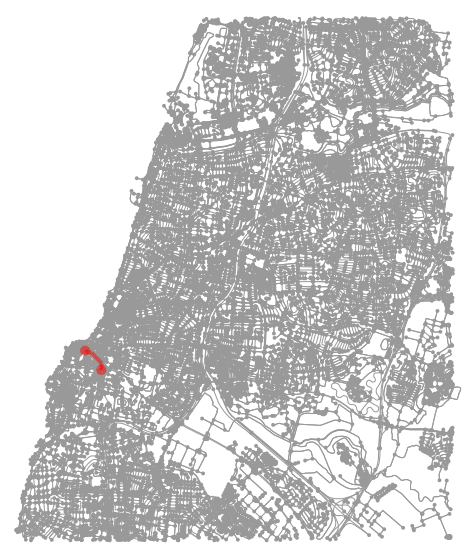

Sabil Abu Nabbut


In [ ]:
WikiRoute((32.053651, 34.754659),(32.084281, 34.809537),100)